<a href="https://colab.research.google.com/github/incerasita/ADA/blob/main/Lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling
Topic Modeling is a type of statistical modeling for discovering the abstract "topics" that occur in a collection of documents. It is a frequent technique in text mining for uncovering hidden semantic structures in a text body. This process is useful in various applications like organizing large archives of texts, summarizing information, and aiding in understanding the main themes of texts without reading them in full. We will look at several techniques for topic modeling including LDA, LSA, NMF and BERTopic.


## LDA

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download() to look at options

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [4]:
# Function to preprocess the data
def preprocess_texts(documents):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    preprocessed_texts = []
    for text in documents:
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        preprocessed_texts.append(tokens)  # Append list of tokens directly, without joining them into a string

    return preprocessed_texts


In [5]:
# Sample data and preprocessing
documents = [
    "Sugar is bad to consume. My sister likes to have sugar, but not my father.",
    "My father spends a lot of time driving my brother around to baseball practice.",
    "Some health experts suggest that driving may cause increased stress and blood pressure.",
    "I often feel pressure to perform well at school, but my father never seems to drive my sister to do better.",
    "Health professionals say that Sugar is not good for your lifestyle."
]

# 'texts' will be a list of lists of tokens
texts = preprocess_texts(documents)

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]


In [6]:
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.085*"sugar" + 0.061*"health" + 0.037*"driving" + 0.037*"say" + 0.037*"good"')
(1, '0.065*"father" + 0.039*"sister" + 0.039*"pressure" + 0.038*"driving" + 0.038*"seems"')


The variations in output each time you run an LDA model are due to the stochastic nature of the algorithms used in Latent Dirichlet Allocation. Here are the key reasons for these variations:

* Random Initialization: Most LDA implementations (including gensim) start with a random initialization of the topic assignments for each word. This randomness affects the subsequent updates and iterations of the algorithm.

* Sampling Methods: LDA often uses sampling methods like Gibbs sampling or variational Bayes inference to estimate the distributions of topics over words and documents. These methods inherently involve randomness, which can lead to different results each time the model is trained, especially if the number of iterations is not large enough to reach convergence.

* Convergence Issues: If the LDA model doesn't fully converge due to too few iterations or poor parameter settings (like learning rates), the output may vary significantly between runs. Achieving convergence in probabilistic models can be challenging and might require tuning parameters such as the number of iterations and choosing appropriate hyperparameters (like alpha and beta for LDA).

* Number of Topics: The choice of the number of topics (num_topics) can also influence the stability of your topics. Too few or too many topics can lead to overfitting or underfitting, respectively, making the model sensitive to initial conditions or specific samples of data.

### Ensuring Consistency

To reduce the variability in your LDA models, you can take the following steps:

* Set a Random Seed: Most LDA implementations allow you to set a random seed to make the results reproducible. This is done by fixing the seed for the random number generator used by the model.

* Increase the Number of Iterations: Allowing more iterations can help the model converge more consistently, which, in turn, makes the output more stable.

* Tune Hyperparameters: Adjusting the hyperparameters, such as alpha (document-topic density) and beta (topic-word density), can help in achieving better and more consistent results. These parameters control the sparsity of the topics extracted by the model.

* Extensive Preprocessing: More consistent and thorough preprocessing of the text data can lead to less noise in the input, which helps stabilize the output.

```
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',  # can be set as a scalar like '0.01' or 'auto' for learning the optimal alpha
    eta='auto'     # eta is another name for beta in gensim, similarly settable
)
```




In [14]:
# Set parameters
num_topics = 5
passes = 100 #increase number of passes, will help to stabilize

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes,random_state=100)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.084*"driving" + 0.046*"health" + 0.046*"blood" + 0.046*"expert" + 0.046*"may"')
(1, '0.028*"father" + 0.028*"health" + 0.028*"sister" + 0.028*"pressure" + 0.028*"professional"')
(2, '0.028*"father" + 0.028*"health" + 0.028*"sister" + 0.028*"pressure" + 0.028*"professional"')
(3, '0.158*"sugar" + 0.059*"bad" + 0.059*"consume" + 0.059*"like" + 0.059*"health"')
(4, '0.063*"father" + 0.063*"sister" + 0.063*"pressure" + 0.062*"never" + 0.062*"drive"')


We can also display the topics as wordclouds:

In [8]:
%pip install wordcloud

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

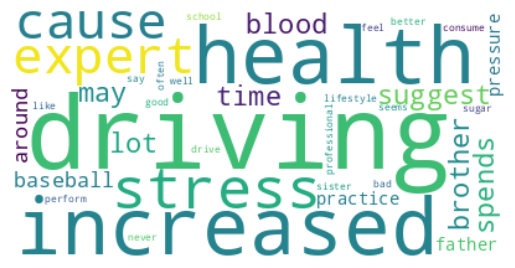

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, 200)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt

create_wordcloud(lda, topic=0)
#how do I name topic 0

#Coherence Score
Coherence measures the degree of semantic similarity between high scoring words in the topic. These scores help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [12]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


Coherence Score: 0.35277825048982697


# Number of Topics

[0.3076742654074003, 0.35277825048982697, 0.36186683579444917, 0.3833486338856585]


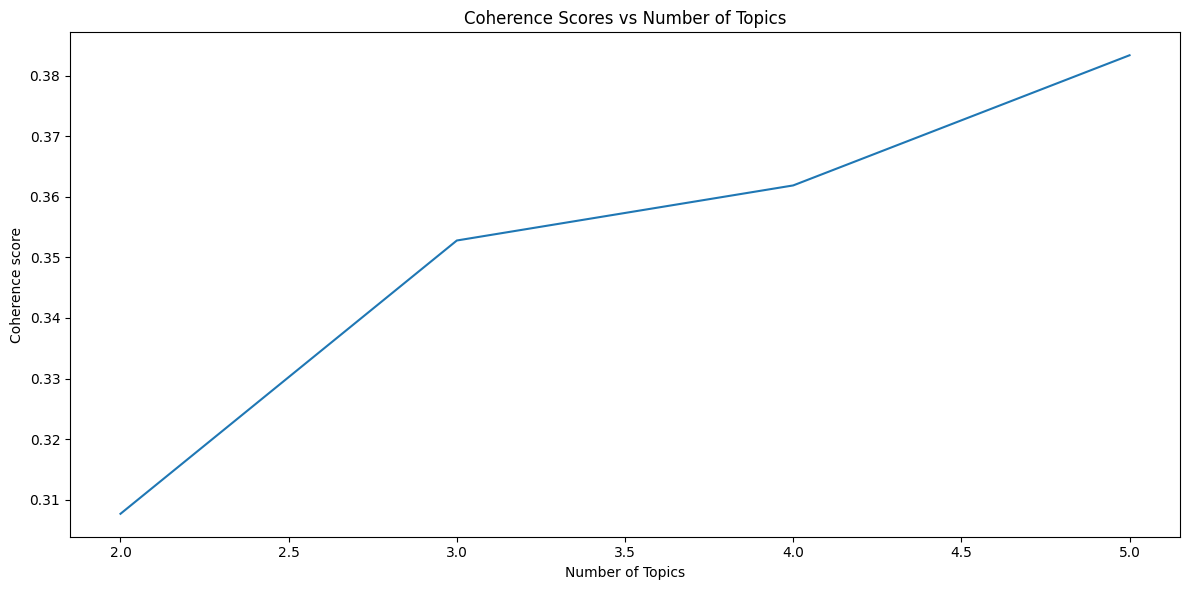

In [13]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()

#As choose more number of topics, the coherence increase (maybe 4 or 5 in this case)

# LSA

In [16]:
from gensim.models import LdaModel,CoherenceModel,TfidfModel,Nmf,LsiModel

In [20]:
# train LSA model
num_topics = 2
lsa_model = LsiModel(corpus, num_topics=num_topics, id2word=dictionary,random_seed=100)
topics = lsa_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

coherence_model_lsa = CoherenceModel(model=lsa_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score:', coherence_lsa)

#result : top5 of words in each topics with coherence
#aim : to maximize Coherence score

(0, '0.406*"father" + 0.323*"sister" + 0.290*"pressure" + 0.273*"sugar" + 0.207*"drive"')
(1, '-0.359*"driving" + -0.304*"health" + -0.271*"blood" + -0.271*"expert" + -0.271*"increased"')
Coherence Score: 0.365572590538774


##NMF

In [23]:
# train NMF model
num_topics =3
nmf_model = Nmf(corpus,id2word=dictionary, num_topics=num_topics,passes=20,random_state=100)
topics = nmf_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

coherence_model_nmf = CoherenceModel(model=nmf_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('Coherence Score:', coherence_nmf)

#3 result the highest Coherence Score in this case

(0, '0.101*"driving" + 0.098*"expert" + 0.098*"increased" + 0.098*"blood" + 0.098*"stress"')
(1, '0.095*"sister" + 0.089*"father" + 0.070*"never" + 0.070*"perform" + 0.070*"drive"')
(2, '0.098*"sugar" + 0.077*"father" + 0.062*"time" + 0.062*"baseball" + 0.062*"lot"')
Coherence Score: 0.333626728563668


##LSA vs NMF
* Comparison and Use Cases Interpretability: NMF often provides more interpretable topics than LSA because of the non-negativity constraint, which aligns better with the intuitive notion of adding up features to form a dataset.
* Handling of Synonyms and Polysemy: LSA can handle synonyms better due to its dimensional reduction approach, but it struggles with polysemy (words with multiple meanings) because all occurrences of a word are mapped to a single point in semantic space.
* Usage: LSA is often preferred for tasks involving similarity and information retrieval due to its robust handling of noise and ability to capture underlying semantic patterns. NMF is favored for clustering and classification tasks where interpretability of components (topics) is crucial.

 Both LSA and NMF are valuable tools in the text mining and information retrieval toolkit, chosen based on the specific requirements of clarity, ease of interpretation, and the nature of the text data.

## BERT Topic Modeling
BERTopic is a topic modeling tool that leverages transformers and language models like BERT for generating topics from textual data. Unlike traditional methods such as LDA, BERTopic utilizes contextual embeddings, which can capture the meanings of words more effectively in different contexts.

Since the example we have used thus far is too small for this technique (due to embeddings - we will discuss this later), we will use the first 100 reviews from the ``Reviews.csv`` file.

Fine-Tune Model

In [ ]:
%pip install bertopic

In [25]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
import pandas as pd

# Load the dataset and read the first 100 rows
#file_path = 'Reviews.csv'
#df = pd.read_csv(file_path,nrows=100)

df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=100)

# Display the first few rows of the dataset and columns to identify the 'Review' column
df.head(), df.columns


(   Clothing ID  Age                              Title  \
 0            0   26                                NaN   
 1            1   50    Love this under-all cami tank ?   
 2            1   36                       Staple tank!   
 3            1   24        Love but also very annoying   
 4            2   28  Gorgeous top, straps way too long   
 
                                               Review  Rating  Recommended  \
 0                                                NaN       5            1   
 1  Originally i bought this in black and white. r...       5            1   
 2  Love this tank. material and fit are great. lo...       5            1   
 3  I love this tank, it is so comfortable but it ...       2            0   
 4  I just adore this top! it is so comfy and styl...       4            1   
 
    PositiveFeedbackCount   Division Department      Class        Date  
 0                      0    General    Jackets  Outerwear  02/03/2018  
 1                      0  I

In [27]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)

In [28]:
# Remove rows where 'Review' is NaN
df = df.dropna(subset=['Review'])
df['Review']= df['Review'].apply(preprocess_text)

In [ ]:
df

### BERTopic

In [29]:
from bertopic import BERTopic

In [30]:
# Initialize BERTopic
topic_model = BERTopic(language="english", calculate_probabilities=True)

# Fit the model on the limited data
topics, probabilities = topic_model.fit_transform(df['Review'])

# Display the topic info
topic_info = topic_model.get_topic_info()
print(topic_info)

# Optionally, print individual topics
for topic in topic_model.get_topics().items():
    print(topic)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Topic  Count                            Name  \
0     -1     35  -1_love_would_size_comfortable   
1      0     38          0_love_wear_dress_suit   
2      1     16           1_bra_fits_wear_great   

                                      Representation  \
0  [love, would, size, comfortable, tank, feel, o...   
1  [love, wear, dress, suit, size, perfect, like,...   
2  [bra, fits, wear, great, size, cup, got, band,...   

                                 Representative_Docs  
0  [bikini bottoms high quality feel luxurious or...  
1  [sweater comfy classic balances quirky look be...  
2  [undergarments comfortable streamlined well ma...  
(-1, [('love', 0.05949556720448137), ('would', 0.04892831817153054), ('size', 0.0488473244138025), ('comfortable', 0.04158528233447764), ('tank', 0.039559430674171725), ('feel', 0.03868353947810531), ('ordered', 0.03868353947810531), ('one', 0.03868353947810531), ('fabric', 0.038433110248752976), ('bought', 0.038055358577857086)])
(0, [('love', 0.0

In [31]:
for topic in topic_model.get_topics().items():
    topic

### Visualize

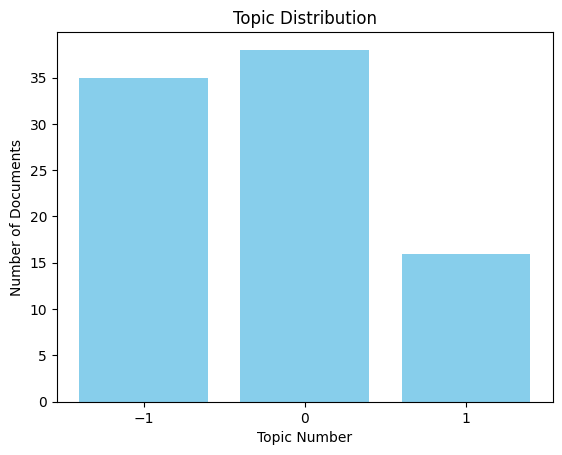

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'topics' contains the output from BERTopic
unique_topics, counts = np.unique(topics, return_counts=True)

# Simple bar chart to show topic distribution
plt.bar(unique_topics, counts, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.xticks(unique_topics)
plt.show()



### Top terms for each topic

In [33]:
data = topic_model.get_topics()
rows = []
for topic, terms in data.items():
    for term, weight in terms:
        rows.append({'topic': topic, 'term': term, 'weight': weight})
df = pd.DataFrame(rows)
sorted_df = df.sort_values(by=['topic', 'weight'], ascending=[True, False])
print(sorted_df)

#which word belong to which topic with their weight

    topic         term    weight
0      -1         love  0.059496
1      -1        would  0.048928
2      -1         size  0.048847
3      -1  comfortable  0.041585
4      -1         tank  0.039559
5      -1         feel  0.038684
6      -1      ordered  0.038684
7      -1          one  0.038684
8      -1       fabric  0.038433
9      -1       bought  0.038055
10      0         love  0.055007
11      0         wear  0.049298
12      0        dress  0.048516
13      0         suit  0.045502
14      0         size  0.044706
15      0      perfect  0.043109
16      0         like  0.042075
17      0        great  0.036870
18      0          fit  0.035924
19      0          top  0.035049
20      1          bra  0.133139
21      1         fits  0.064595
22      1         wear  0.061093
23      1        great  0.053306
24      1         size  0.052763
25      1          cup  0.052483
26      1          got  0.045244
27      1         band  0.043858
28      1       straps  0.039170
29      1 

# Some practical considerations

In [52]:
# Load the dataset and read the first 100 rows
#file_path = 'Reviews.csv'
#df = pd.read_csv(file_path,nrows=100)
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing
Depending on the context, you may want to focus on terms that have a particular part-of-speech. For this case, let's only keep terms that are nouns and adjectives. Here are the steps to modify the `preprocess_text` function:

* Tokenize the text.
* Use part-of-speech tagging to identify the POS of each token.
* Filter out tokens that are not nouns or adjectives.
* Remove stopwords and non-alphabetic tokens.
* Join the tokens back into a string.

What kind of term we want for a topic ex. NOUN, ADJ

In [53]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens that are nouns or adjectives
    # NN* for nouns, JJ* for adjectives
    tokens = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    return ' '.join(tokens)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
# Remove rows where 'Review' is NaN
df = df.dropna(subset=['Review'])
df['Review']= df['Review'].apply(preprocess_text)

In [ ]:
df[['Review']]

In [39]:
# 'texts' will be a list of lists of tokens
texts = preprocess_texts(df['Review'])

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA

In [40]:
# Set parameters
num_topics = 2
passes = 10 #show only first 10 important words

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.016*"small" + 0.015*"suit" + 0.014*"size" + 0.013*"little" + 0.012*"comfortable" + 0.012*"fit" + 0.012*"tank" + 0.011*"great" + 0.011*"perfect" + 0.011*"color"')
(1, '0.024*"size" + 0.018*"bra" + 0.015*"time" + 0.014*"perfect" + 0.014*"dress" + 0.012*"fit" + 0.011*"great" + 0.011*"color" + 0.010*"year" + 0.009*"comfortable"')


## Choose the number of topics

[0.2775663720454346, 0.3028677466800543, 0.33696836370938066, 0.3266251284126911]


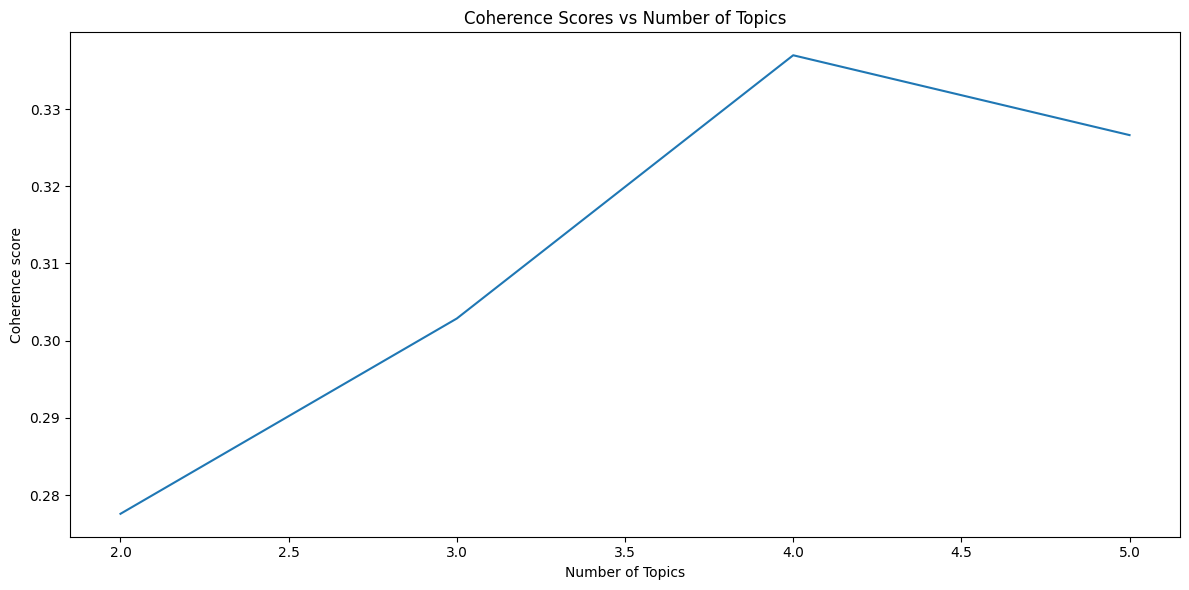

In [41]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()

#4 topics seem to be good number

In [42]:
# Set optimal number of topics
num_topics = 4
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.020*"size" + 0.017*"bra" + 0.017*"small" + 0.017*"great" + 0.015*"suit" + 0.014*"little" + 0.013*"color" + 0.013*"perfect" + 0.013*"cup" + 0.011*"fit"')
(1, '0.018*"time" + 0.015*"year" + 0.015*"fabric" + 0.014*"soft" + 0.013*"fit" + 0.012*"much" + 0.012*"comfortable" + 0.012*"super" + 0.009*"bralette" + 0.009*"bra"')
(2, '0.020*"tank" + 0.018*"suit" + 0.017*"size" + 0.017*"fit" + 0.015*"perfect" + 0.013*"dress" + 0.013*"look" + 0.013*"sweater" + 0.013*"great" + 0.011*"strap"')
(3, '0.028*"size" + 0.020*"color" + 0.017*"dress" + 0.014*"comfortable" + 0.013*"perfect" + 0.013*"top" + 0.013*"bra" + 0.013*"panty" + 0.011*"great" + 0.011*"medium"')


## Visualize

### Print top 5 terms in each topic

In [43]:
# Print the top 5 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=5)  # Get the top 5 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

Topic 0: size, bra, small, great, suit
Topic 1: time, year, fabric, soft, fit
Topic 2: tank, suit, size, fit, perfect
Topic 3: size, color, dress, comfortable, perfect


## Interactive Web-based Visualization

In [ ]:
%pip install pyLDAvis

In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Assume `lda` is the LDA model and `corpus` and `dictionary` are your corpus and dictionary from Gensim

# Prepare the visualization data
vis_data = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization in a Jupyter Notebook (or in an IPython environment)
pyLDAvis.display(vis_data)

# To save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
#download the file

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


# Your Turn
Conduct topic modeling with `sms_spam.csv`and `oct_delta.csv` data.

In [83]:
df = pd.read_csv('sms_spam.csv')
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will Ã¼ b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [84]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens that are nouns or adjectives
    # NN* for nouns, JJ* for adjectives
    tokens = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    return ' '.join(tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# Remove rows where 'text' is NaN
df = df.dropna(subset=['text'])
df['text']= df['text'].apply(preprocess_text)

df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,type,text
0,ham,jurong point crazy available bugis great world...
1,ham,ok lar wif u oni
2,spam,free entry wkly comp fa cup final tkts text fa...
3,ham,u dun early hor u c
4,ham,nah
...,...,...
5569,spam,time contact u pound prize claim easy minute
5570,ham,b fr home
5571,ham,pity mood suggestions
5572,ham,guy bitching interested something next week free


In [ ]:
# 'texts' will be a list of lists of tokens
texts = preprocess_texts(df['text'])

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

In [59]:
#LDA
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.018*"gt" + 0.016*"free" + 0.015*"lt" + 0.012*"call" + 0.009*"mobile" + 0.009*"text" + 0.009*"sorry" + 0.008*"new" + 0.008*"phone" + 0.008*"week"')
(1, '0.053*"u" + 0.014*"ur" + 0.011*"ok" + 0.010*"good" + 0.009*"day" + 0.009*"time" + 0.008*"lor" + 0.008*"home" + 0.007*"da" + 0.006*"r"')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.25992806591889556, 0.3596615540392846, 0.3639859282237745, 0.33543130606707183]


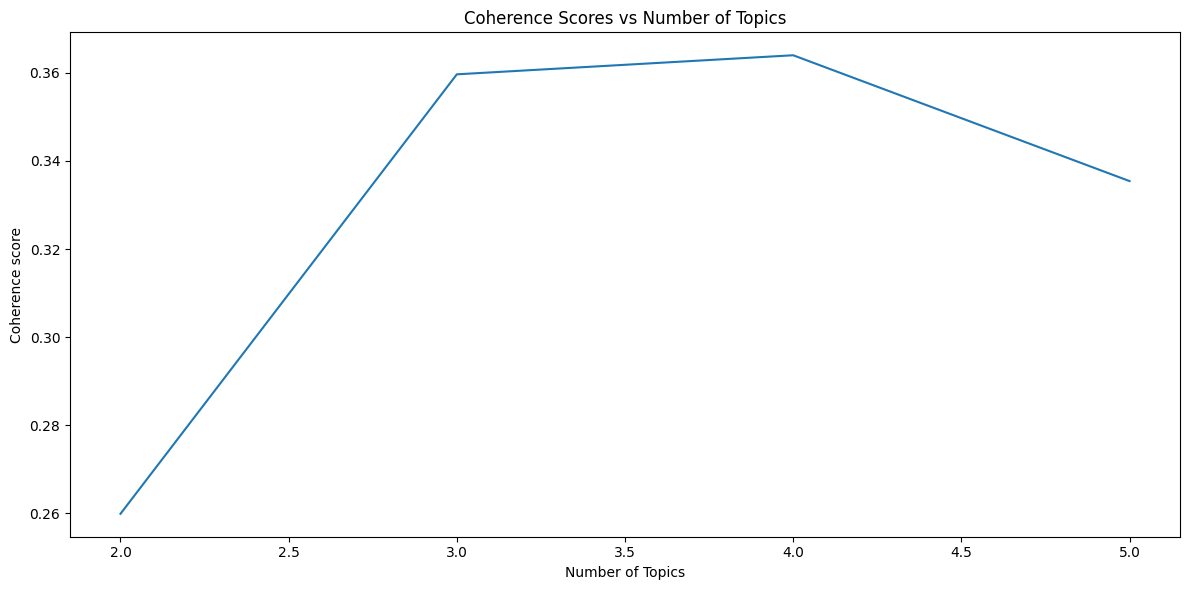

In [60]:
# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()


In [61]:
# Set optimal number of topics
num_topics = 4
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

#coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
#coherence_nmf = coherence_model_nmf.get_coherence()
#print('Coherence Score:', coherence_nmf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.022*"ur" + 0.012*"c" + 0.011*"tone" + 0.011*"week" + 0.010*"text" + 0.008*"free" + 0.008*"cash" + 0.006*"today" + 0.006*"txt" + 0.006*"chance"')
(1, '0.029*"gt" + 0.024*"lt" + 0.020*"day" + 0.017*"u" + 0.016*"good" + 0.012*"sorry" + 0.011*"great" + 0.010*"k" + 0.009*"happy" + 0.009*"love"')
(2, '0.046*"u" + 0.022*"free" + 0.014*"call" + 0.014*"mobile" + 0.014*"phone" + 0.011*"message" + 0.011*"hi" + 0.009*"prize" + 0.009*"new" + 0.009*"text"')
(3, '0.044*"u" + 0.021*"time" + 0.017*"lor" + 0.016*"ok" + 0.015*"da" + 0.013*"home" + 0.011*"hey" + 0.009*"wat" + 0.007*"today" + 0.007*"n"')


In [62]:
# Print the top 5 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=5)  # Get the top 5 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

Topic 0: ur, c, tone, week, text
Topic 1: gt, lt, day, u, good
Topic 2: u, free, call, mobile, phone
Topic 3: u, time, lor, ok, da


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
# Assume `lda` is the LDA model and `corpus` and `dictionary` are your corpus and dictionary from Gensim

# Prepare the visualization data
vis_data = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization in a Jupyter Notebook (or in an IPython environment)
pyLDAvis.display(vis_data)

# To save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization2.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
df = pd.read_csv('oct_delta.csv')
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,weekday,month,date,year,text
0,Thu,Oct,1,2015,@mjdout I know that can be frustrating..we hop...
1,Thu,Oct,1,2015,@rmarkerm Terribly sorry for the inconvenience...
2,Thu,Oct,1,2015,"@checho85 I can check, pls follow and DM your..."
3,Thu,Oct,1,2015,"@nealaa ...Alerts, pls check here: http://t.co..."
4,Thu,Oct,1,2015,@nealaa ...advisory has only been issued for t...
...,...,...,...,...,...
1372,Thu,Oct,15,2015,@satijp Woohoo! Way to go Marla and Mira! Happ...
1373,Thu,Oct,15,2015,@lukenbaugh1 You're welcome! Have a great day!...
1374,Thu,Oct,15,2015,"@jeffcarp If you do not make your connection,..."
1375,Thu,Oct,15,2015,@jeffcarp ...719pm. *DD 2/2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.025*"confirmation" + 0.020*"sorry" + 0.019*"hi" + 0.019*"team" + 0.017*"pls" + 0.017*"apology" + 0.015*"thanks" + 0.014*"ng" + 0.012*"aa" + 0.011*"delay"')
(1, '0.021*"flight" + 0.018*"hi" + 0.016*"sorry" + 0.014*"number" + 0.013*"thank" + 0.013*"pl" + 0.012*"rd" + 0.011*"mr" + 0.011*"team" + 0.010*"ml"')
[0.26321062278146035, 0.31752930017056774, 0.3276548429765935, 0.3535027681937032]


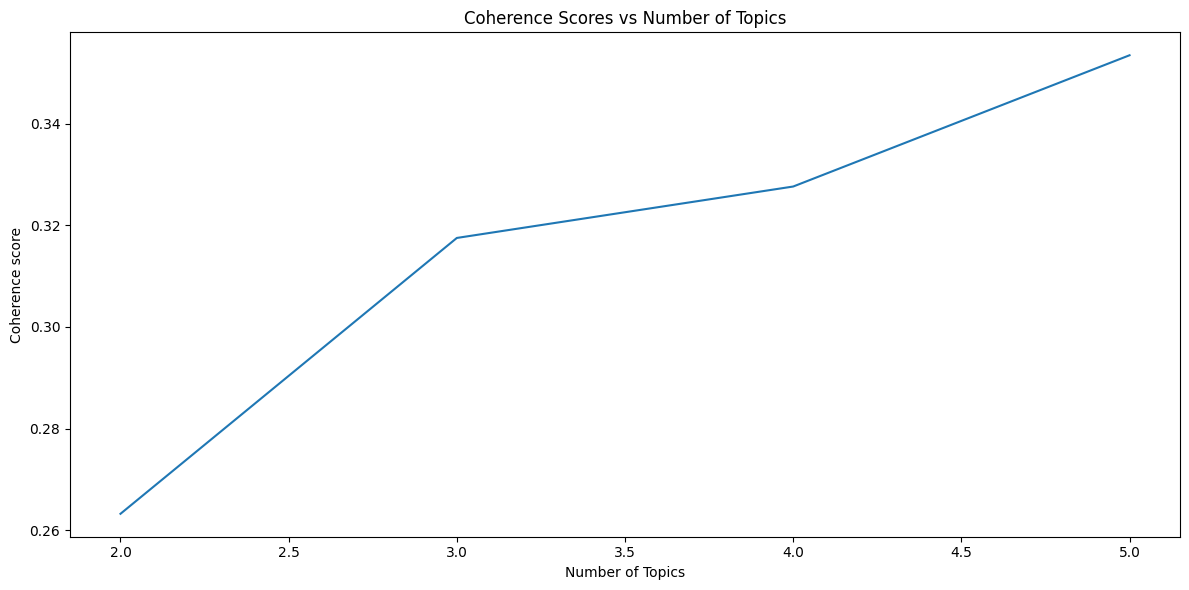

In [94]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens that are nouns or adjectives
    # NN* for nouns, JJ* for adjectives
    tokens = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    return ' '.join(tokens)

# Remove rows where 'text' is NaN
df = df.dropna(subset=['text'])
df['text']= df['text'].apply(preprocess_text)

# 'texts' will be a list of lists of tokens
texts = preprocess_texts(df['text'])

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

#LDA
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()

In [95]:
# Set optimal number of topics
num_topics = 3
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Print the top 5 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=5)  # Get the top 5 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

# Assume `lda` is the LDA model and `corpus` and `dictionary` are your corpus and dictionary from Gensim

# Prepare the visualization data
vis_data = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization in a Jupyter Notebook (or in an IPython environment)
pyLDAvis.display(vis_data)

# To save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization3.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.038*"confirmation" + 0.032*"number" + 0.031*"hi" + 0.019*"look" + 0.017*"please" + 0.017*"follow" + 0.016*"wg" + 0.013*"pls" + 0.012*"ticket" + 0.011*"amp"')
(1, '0.021*"pl" + 0.020*"good" + 0.019*"assistance" + 0.014*"sorry" + 0.014*"vm" + 0.014*"ng" + 0.012*"thanks" + 0.012*"flight" + 0.011*"pls" + 0.011*"time"')
(2, '0.028*"team" + 0.027*"sorry" + 0.020*"hi" + 0.016*"welcome" + 0.015*"thank" + 0.014*"happy" + 0.013*"ng" + 0.013*"flight" + 0.013*"thanks" + 0.012*"apology"')
Topic 0: confirmation, number, hi, look, please
Topic 1: pl, good, assistance, sorry, vm
Topic 2: team, sorry, hi, welcome, thank


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
